## Introduction 

For this week, we were tasked with completing the "I'm Something of a Painter Myself" competition in Kaggle. This challenge is centered around GAN models and being able to generate images similar to a monet style painting based on the training and testing sets. This will be my first foray into image creation using a GAN, so I'm hoping to create some relatively simple models in order to test out how GANs function. Most of the code will likely look similar to this example hosted by Keras: https://keras.io/examples/generative/cyclegan/#:~:text=CycleGAN%20is%20a%20model%20that,examples%20isn%27t%20always%20feasible. I will do what I can to tune hyper-parameters and explain the methods that I'm using.

## EDA and Preprocessing

In terms of EDA, the first things we'll want to do will be to import the files, and view a few simple images. We'll need to decode the images first, then we will look to do a bit of preprocessing in terms of standardizing and randomizing the images themselves.

In [1]:
import tensorflow as tf
import re
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from kaggle_datasets import KaggleDatasets as KD
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

2022-12-04 20:02:12.023465: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-12-04 20:02:12.023664: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Device: grpc://10.0.0.2:8470


2022-12-04 20:02:17.548531: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-04 20:02:17.552030: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-12-04 20:02:17.552074: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-04 20:02:17.552102: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (10113208607a): /proc/driver/nvidia/version does not exist
2022-12-04 20:02:17.556289: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Number of replicas: 8
2.4.1


In [2]:
path = KD().get_gcs_path()

In [3]:
photoFilenames = tf.io.gfile.glob(str(path + '/photo_tfrec/*.tfrec'))
print('Photo tfRecord Files:', len(photoFilenames))

monetFilenames = tf.io.gfile.glob(str(path + '/monet_tfrec/*.tfrec'))
print('Monet tfRecord Files:', len(monetFilenames))

SIZE = 256
SIZE_RESIZE = 128
BATCH_SIZE = 16

Photo tfRecord Files: 20
Monet tfRecord Files: 5


2022-12-04 20:02:24.265721: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-04 20:02:24.316059: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [4]:
imgSize = [256, 256]

def decode_image(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = (tf.cast(img, tf.float32) / 127.5) - 1
    img = tf.reshape(img, [*imgSize, 3])
    return img

def read_record(exm):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    exm = tf.io.parse_single_example(exm, tfrecord_format)
    img = decode_image(exm['image'])
    return img

In [5]:
def load_dataset(filenames, apply_jitter=False, repeat=True, shuffle=True, batch_size=BATCH_SIZE):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_record, num_parallel_calls=AUTOTUNE)
    
    if apply_jitter:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE)
            
    if repeat:
        dataset = dataset.repeat()
    if shuffle:
        dataset = dataset.shuffle(512)
        
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    
    return dataset

In [6]:
monetPhotos = load_dataset(monetFilenames)
photos = load_dataset(photoFilenames)

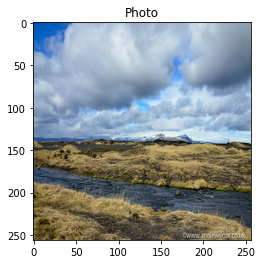

In [7]:
Photo = next(iter(photos))
plt.title('Photo')
plt.imshow(Photo[0] * 0.5 + 0.5)

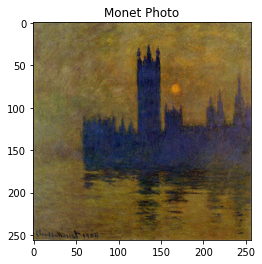

In [8]:
monetPhoto = next(iter(monetPhotos))
plt.title('Monet Photo')
plt.imshow(monetPhoto[0] * 0.5 + 0.5)

Now that we've seen a sample image from each dataset, let's augment the data to provide some standardization and cropping.

In [9]:
def DiffAugment(x, policy='', channels_first=False):
    if policy:
        if channels_first:
            x = tf.transpose(x, [0, 2, 3, 1])
        for p in policy.split(','):
            for f in AUGMENT_FNS[p]:
                x = f(x)
        if channels_first:
            x = tf.transpose(x, [0, 3, 1, 2])
    return x


def rand_brightness(x):
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) - 0.5
    x = x + magnitude
    return x


def rand_saturation(x):
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) * 2
    x_mean = tf.reduce_mean(x, axis=3, keepdims=True)
    x = (x - x_mean) * magnitude + x_mean
    return x


def rand_contrast(x):
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) + 0.5
    x_mean = tf.reduce_mean(x, axis=[1, 2, 3], keepdims=True)
    x = (x - x_mean) * magnitude + x_mean
    return x


def rand_translation(x, ratio=0.125):
    batch_size = tf.shape(x)[0]
    image_size = tf.shape(x)[1:3]
    shift = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
    translation_x = tf.random.uniform([batch_size, 1], -shift[0], shift[0] + 1, dtype=tf.int32)
    translation_y = tf.random.uniform([batch_size, 1], -shift[1], shift[1] + 1, dtype=tf.int32)
    grid_x = tf.clip_by_value(tf.expand_dims(tf.range(image_size[0], dtype=tf.int32), 0) + translation_x + 1, 0, image_size[0] + 1)
    grid_y = tf.clip_by_value(tf.expand_dims(tf.range(image_size[1], dtype=tf.int32), 0) + translation_y + 1, 0, image_size[1] + 1)
    x = tf.gather_nd(tf.pad(x, [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_x, -1), batch_dims=1)
    x = tf.transpose(tf.gather_nd(tf.pad(tf.transpose(x, [0, 2, 1, 3]), [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_y, -1), batch_dims=1), [0, 2, 1, 3])
    return x


def rand_cutout(x, ratio=0.5):
    batch_size = tf.shape(x)[0]
    image_size = tf.shape(x)[1:3]
    cutout_size = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
    offset_x = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[0] + (1 - cutout_size[0] % 2), dtype=tf.int32)
    offset_y = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[1] + (1 - cutout_size[1] % 2), dtype=tf.int32)
    grid_batch, grid_x, grid_y = tf.meshgrid(tf.range(batch_size, dtype=tf.int32), tf.range(cutout_size[0], dtype=tf.int32), tf.range(cutout_size[1], dtype=tf.int32), indexing='ij')
    cutout_grid = tf.stack([grid_batch, grid_x + offset_x - cutout_size[0] // 2, grid_y + offset_y - cutout_size[1] // 2], axis=-1)
    mask_shape = tf.stack([batch_size, image_size[0], image_size[1]])
    cutout_grid = tf.maximum(cutout_grid, 0)
    cutout_grid = tf.minimum(cutout_grid, tf.reshape(mask_shape - 1, [1, 1, 1, 3]))
    mask = tf.maximum(1 - tf.scatter_nd(cutout_grid, tf.ones([batch_size, cutout_size[0], cutout_size[1]], dtype=tf.float32), mask_shape), 0)
    x = x * tf.expand_dims(mask, axis=3)
    return x


AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'translation': [rand_translation],
    'cutout': [rand_cutout],
}

def aug_fn(image):
        return DiffAugment(image,"translation,cutout")

In [10]:
both_images = tf.concat([monetPhoto, Photo], axis=0)       
aug_images = aug_fn(both_images)
newMonet, newPhoto = tf.split(aug_images, num_or_size_splits=2, axis=0)

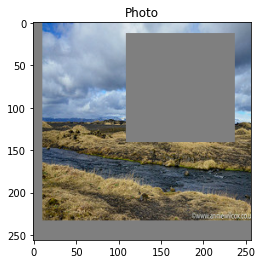

In [11]:
plt.title('Photo')
plt.imshow(newPhoto[0] * 0.5 + 0.5)

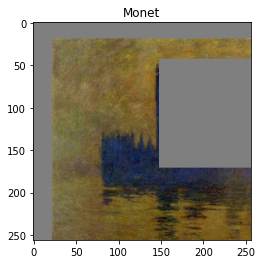

In [12]:
plt.title('Monet')
plt.imshow(newMonet[0] * 0.5 + 0.5)

We can see from the above "new" photos, that we're randomly cropping, rotating, changing the brightness, as well as translating randoms parts of each photo in order to prepare the data for training purposes. The data should now be ready to create the discriminators, generators, and ultimately the model itself.

## Model Architecture and Training

For the model, I'll be creating a CycleGAN with a ResNet Generator like they do in the example that I mentioned in the introduction. The reason for this is because residual networks allow the residual connections allow the model to learn from the identity functions in the data. A similar approach was taken in this paper from Stanford: https://cs230.stanford.edu/projects_spring_2018/reports/8289557.pdf. 


In [13]:
def Downsample(X, filter_count, kernel_size, padding, stride, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    X = tf.keras.layers.ZeroPadding2D((padding,padding))(X)
    X = tf.keras.layers.Conv2D(filter_count, (kernel_size,kernel_size), padding='valid', strides=(stride,stride), 
                                      kernel_initializer=initializer, use_bias=False)(X)
    
    if apply_norm:
        X = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(X)
    
    X = tf.keras.layers.LeakyReLU()(X)
    
    return X

def Upsample(X, filter_count, kernel_size, stride, activation='relu', apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    X = tf.keras.layers.Conv2DTranspose(filter_count, (kernel_size,kernel_size), padding='same', strides=(stride,stride), 
                                        kernel_initializer=initializer, use_bias=False)(X)
    
    if apply_norm:
        X = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(X)
        
    X = tf.keras.layers.Activation(activation)(X)
    
    return X

def ResidualBlock(X):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    X_shortcut = X
    
    # Layer 1   
    X = tf.keras.layers.ZeroPadding2D((1,1))(X)
    X = tf.keras.layers.Conv2D(256, (3,3), padding='valid', strides=(1,1), kernel_initializer=initializer, use_bias=False)(X)
    X = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(X)
    X = tf.keras.layers.Activation('relu')(X)
    
    # Layer 2  
    X = tf.keras.layers.ZeroPadding2D((1,1))(X)
    X = tf.keras.layers.Conv2D(256, (3,3), padding='valid', strides=(1,1), kernel_initializer=initializer, use_bias=False)(X)
    X = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(X)
    
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    
    return X

In [14]:
def ResNetGenerator(height=SIZE, width=SIZE):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    X_input = tf.keras.layers.Input((height, width, 3))
    
    skips = []
    
    X = Downsample(X_input, 64, 7, 3, 1, apply_norm=False)
    skips.append(X)
    
    X = Downsample(X, 128, 3, 1, 2)
    skips.append(X)
    
    X = Downsample(X, 256, 3, 1, 2)
    
    X = ResidualBlock(X)
    X = ResidualBlock(X)
    X = ResidualBlock(X)
    X = ResidualBlock(X)
    X = ResidualBlock(X)
    X = ResidualBlock(X)
    
    skips = list(reversed(skips))
        
    X = Upsample(X, 128, 4, 2)
    X = tf.keras.layers.Concatenate()([X, skips[0]])
    
    X = Upsample(X, 64, 4, 2)
    X = tf.keras.layers.Concatenate()([X, skips[1]])
    
    X = Upsample(X, 3, 7, 1, activation='tanh', apply_norm=False)
    
    model = tf.keras.models.Model(inputs=X_input, outputs=X)

    return model

def Discriminator(height=SIZE, width=SIZE):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    X_input = tf.keras.layers.Input((height, width, 3))

    X = Downsample(X_input, 64, 4, 1, 2, apply_norm=False)
    X = Downsample(X, 128, 4, 1, 2)
    X = Downsample(X, 256, 4, 1, 2)
    X = Downsample(X, 512, 4, 1, 1)
    
    X = tf.keras.layers.ZeroPadding2D()(X)
    X = tf.keras.layers.Conv2D(1, (4,4), padding='valid', strides=(1,1), kernel_initializer=initializer, use_bias=False)(X)   
    X = tf.keras.layers.Activation('sigmoid')(X)
    
    model = tf.keras.models.Model(inputs=X_input, outputs=X)

    return model

In [15]:
resGenerator = ResNetGenerator()
resGenerator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 256, 64) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [16]:
with strategy.scope():
    monet_generator = ResNetGenerator(height=None, width=None) # regular photo to Monet type photo
    photo_generator = ResNetGenerator(height=None, width=None) # Monet photo to regular type photo

    monet_discriminator = Discriminator(height=None, width=None) # determines whether it's a real photo or Monet
    photo_discriminator = Discriminator(height=None, width=None) # determines whether it's a real photo or generated example

Let's create a sample Monet photo from one of our regular photos:

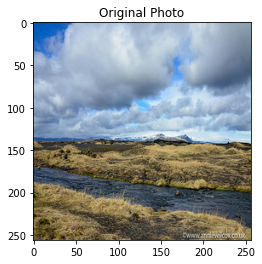

In [17]:
newMonetFromReg = monet_generator(Photo)

plt.title("Original Photo")
plt.imshow(Photo[0] * 0.5 + 0.5)

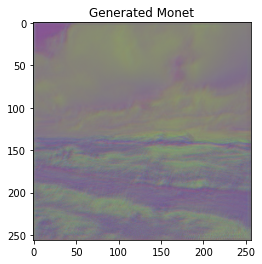

In [18]:
plt.title("Generated Monet")
plt.imshow(newMonetFromReg[0] * 0.5 + 0.5)
plt.show()

Obviously right now there hasn't been any training, but the idea that you can still kind of see the trees is nice at this point.

In [19]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # Diff Augmentation Start
            both_monet = tf.concat([real_monet, fake_monet], axis=0)      
            both_photo = tf.concat([real_photo, fake_photo], axis=0)            
            
            aug_monet = aug_fn(both_monet)
            aug_photo = aug_fn(both_photo)
            
            aug_real_monet, aug_fake_monet = tf.split(aug_monet, num_or_size_splits=2, axis=0)
            aug_real_photo, aug_fake_photo = tf.split(aug_photo, num_or_size_splits=2, axis=0)
            # Diff Augmentation End
            
            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(aug_real_monet, training=True)
            disc_real_photo = self.p_disc(aug_real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(aug_fake_monet, training=True)
            disc_fake_photo = self.p_disc(aug_fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [20]:
with strategy.scope():
    def discriminator_loss_fn(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5
    
    def generator_loss_fn(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return LAMBDA * loss1
    
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [21]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
        p_gen_optimizer = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
        m_disc_optimizer = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
        p_disc_optimizer = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
        gen_loss_fn = generator_loss_fn,
        disc_loss_fn = discriminator_loss_fn,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [22]:
history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monetPhotos, photos)),
    epochs=10,
    steps_per_epoch = 500
).history

Epoch 1/10
500/500 [==============================] - 441s 550ms/step - monet_gen_loss: 2.9931 - photo_gen_loss: 3.0536 - monet_disc_loss: 0.6338 - photo_disc_loss: 0.6186
Epoch 2/10
500/500 [==============================] - 275s 550ms/step - monet_gen_loss: 2.2826 - photo_gen_loss: 2.4056 - monet_disc_loss: 0.6236 - photo_disc_loss: 0.5997
Epoch 3/10
500/500 [==============================] - 275s 550ms/step - monet_gen_loss: 2.1867 - photo_gen_loss: 2.2854 - monet_disc_loss: 0.6047 - photo_disc_loss: 0.5994
Epoch 4/10
500/500 [==============================] - 275s 550ms/step - monet_gen_loss: 2.1334 - photo_gen_loss: 2.2787 - monet_disc_loss: 0.6312 - photo_disc_loss: 0.6029
Epoch 5/10
500/500 [==============================] - 275s 550ms/step - monet_gen_loss: 2.1597 - photo_gen_loss: 2.3255 - monet_disc_loss: 0.6442 - photo_disc_loss: 0.6126
Epoch 6/10
500/500 [==============================] - 275s 550ms/step - monet_gen_loss: 2.1000 - photo_gen_loss: 2.2622 - monet_disc_loss: 0

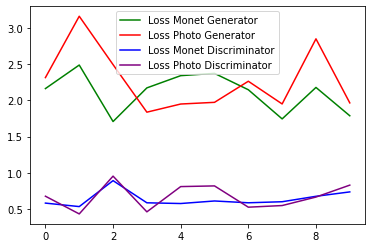

In [23]:
loss_results_df = pd.DataFrame(history)
loss_results_df = loss_results_df.applymap(np.mean)

plt.plot(loss_results_df.index, loss_results_df['monet_gen_loss'], color='green', label='Loss Monet Generator')
plt.plot(loss_results_df.index, loss_results_df['photo_gen_loss'], color='red', label='Loss Photo Generator')
plt.plot(loss_results_df.index, loss_results_df['monet_disc_loss'], color='blue', label='Loss Monet Discriminator')
plt.plot(loss_results_df.index, loss_results_df['photo_disc_loss'], color='purple', label='Loss Photo Discriminator')
plt.legend(loc='best')
plt.show()

Based on the GAN model we were able to make, after 10 epochs the Monet Generator loss was 1.7467 at it's lowest, the Photo Generator loss was 1.7799 at it's lowest, the Monet Discriminator loss was 0.6521 at it's lowest and the Photo Discriminator was 0.65 at it's lowest. While it would be possible to tune hyper parameters in order to create a better model, I'm not going to do so as the process would be extremely computationally expensive, as well as time consuming. Here are a few examples of generated Monet paintings from the original photo:

2022-12-04 20:51:30.643936: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 57140, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670187090.635650241","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 57140, Output num: 0","grpc_status":3}


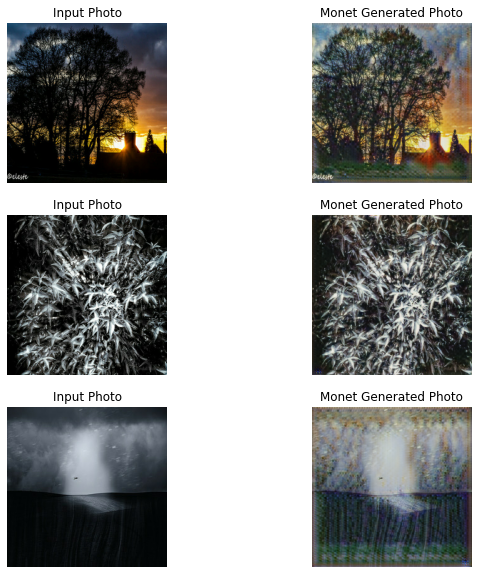

In [24]:
_, ax = plt.subplots(3, 2, figsize=(10, 10))
for i, img in enumerate(photos.take(3)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet Generated Photo")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [25]:
import PIL
import shutil
! mkdir ../images

photos_test = load_dataset(photoFilenames, repeat=False, shuffle=False, batch_size=1)
i = 1
for img in photos_test:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

2022-12-04 21:26:30.958725: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 5011913, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670189190.958602809","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 5011913, Output num: 0","grpc_status":3}


'/kaggle/working/images.zip'

## Conclusion and Results

For my first foray into image generation and GAN models, this worked surprisingly well. The Kaggle screenshot and github link will be in the Coursera page. For the future, I think that this model could be improved by either changing the number of epochs, or the actual architecture of the GAN itself. Using different learning rates, and values for beta_l  could be done through cross-validation in order to find the most effective model. Overall, this is a computationally expensive method, but the results can be incredible and used in a variety of different ways, including making art.